In [31]:
import pickle

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from tqdm import tqdm

from efficient_kan.kan import KAN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [41]:
epochs = 200
patience = 10

In [49]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(Subset(train_dataset, range(len(train_dataset) // 2)), batch_size=64, shuffle=True)
test_loader = DataLoader(Subset(test_dataset, range(len(test_dataset) // 2)), batch_size=64, shuffle=False)

# ARCHITECTURES DEFINITION

In [21]:
class MLP(nn.Module):
    def __init__(self, checkpoint: str | None = None):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 28 * 28)
        self.fc2 = nn.Linear(28 * 28, 256)
        self.fc3 = nn.Linear(256, 10)
        if checkpoint:
            self.load_state_dict(torch.load(checkpoint))
            self.eval()

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class KAN_small(nn.Module):
    def __init__(self, device=device, checkpoint: str | None = None):
        super(KAN_small, self).__init__()
        self.model = KAN([28 * 28, 128, 10]).to(device)
        if checkpoint:
            self.load_state_dict(torch.load(checkpoint))
            self.eval()

    def forward(self, x):
        return self.model(x.view(-1, 28 * 28))

# TRAIN FUNCTION

In [44]:
def train_and_validate(model, train_loader, test_loader, criterion, optimizer, epochs, patience):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in tqdm(range(epochs)):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(test_loader)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        # print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

        if epochs_without_improvement >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break

    return train_losses, val_losses, best_val_loss

In [8]:
def save_results(results, filename):
    with open(filename, 'wb') as f:
        pickle.dump(results, f)


def load_results(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

# TRAINING

In [50]:
for lr in [1e-2]:
    model = KAN_small().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    print(f'Training with learning rate: {lr}')
    train_losses, val_losses, best_val_loss = train_and_validate(model, train_loader, test_loader, criterion, optimizer,
                                                                 epochs, patience)

    results = {
        'learning_rate': lr,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_val_loss': best_val_loss
    }

    save_results(results, f'checkpoint_lr/KAN_lr_{lr}.pkl')

Training with learning rate: 0.01


  6%|▌         | 12/200 [02:24<37:45, 12.05s/it]

Early stopping at epoch 13


# PLOTTING

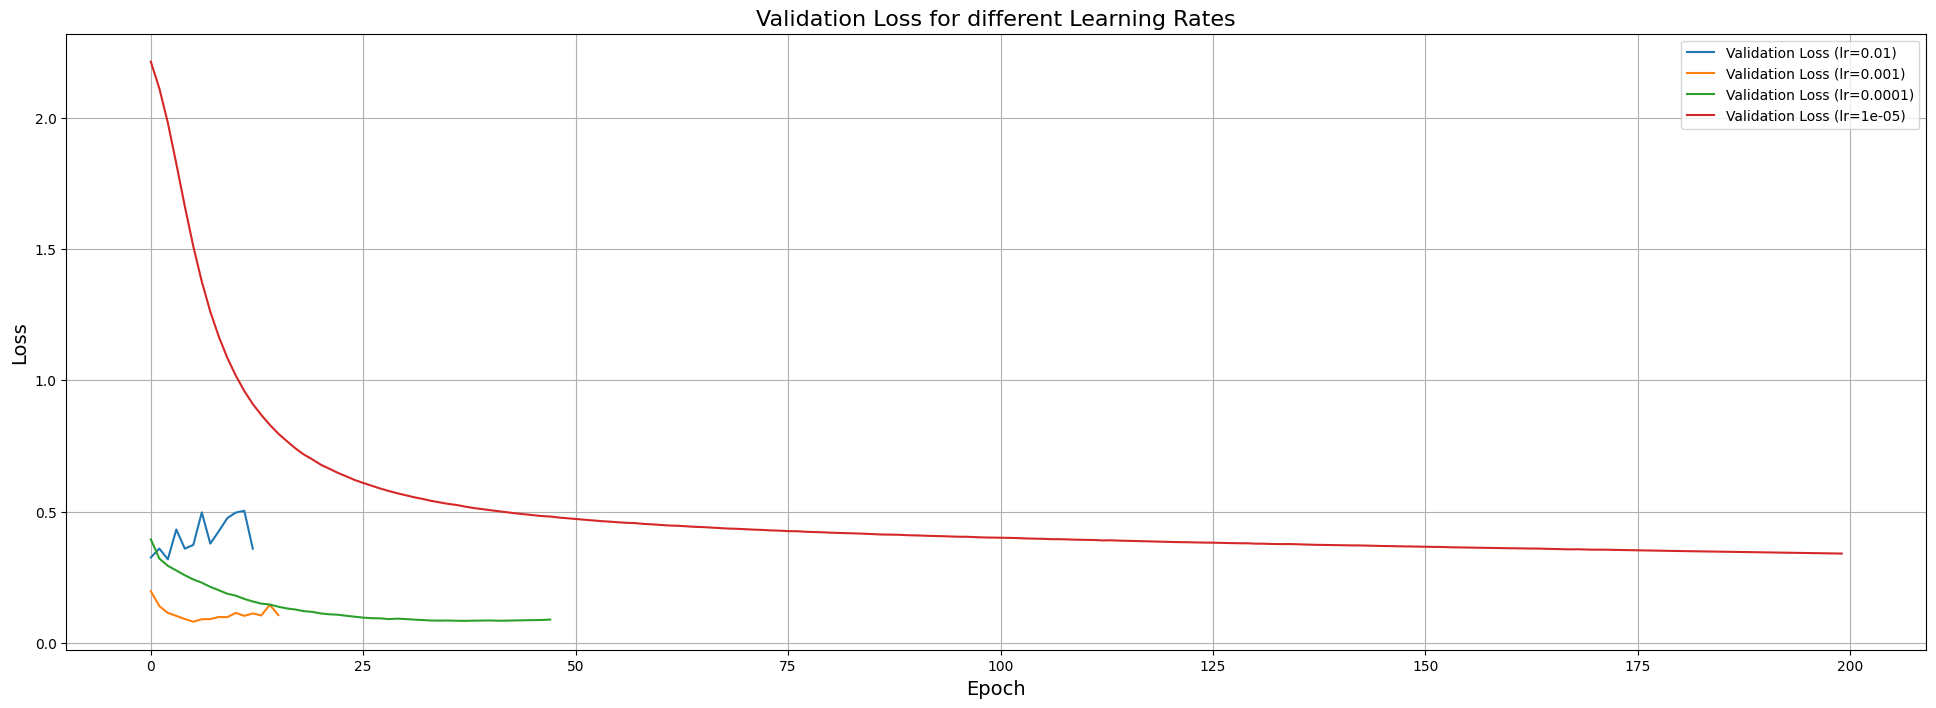

In [53]:
fig, ax = plt.subplots()
for lr in [1e-2, 1e-3, 1e-4, 1e-5][:]:
    results = load_results(f'checkpoint_lr/KAN_lr_{lr}.pkl')
    ax.plot(range(len(results['val_losses'])), results['val_losses'], label=f'Validation Loss (lr={lr})')

plt.legend(loc='upper right')
plt.title('Validation Loss for different Learning Rates', fontdict={'fontsize': 16})
plt.xlabel('Epoch', fontdict={'fontsize': 14})
plt.ylabel('Loss', fontdict={'fontsize': 14})
plt.grid(True)
fig.set_size_inches(24, 8)
plt.show()
